Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
vxvect len = 100
vxvect[0] = 1e-08; Fz_aero[i] = 1.8910000000000003e-16; Fxgrip[i] = 7739.835772397227; Fxaero_[i] = 6.1e-17; Fxdrive[i] = 5937.50000295307; axacc[i] = 8.023648652639285
vxvect[1] = 0.8474747573737376; Fz_aero[i] = 1.3581416611533121; Fxgrip[i] = 7741.170927780182; Fxaero_[i] = 0.43811021327526195; Fxdrive[i] = 6187.765247934673; axacc[i] = 8.3612528888127
vxvect[2] = 1.694949504747475; Fz_aero[i] = 5.432566580510257; Fxgrip[i] = 7745.1761393183015; Fxaero_[i] = 1.752440832422663

Text(42.597222222222214, 0.5, 'axacc (m/s^2)')

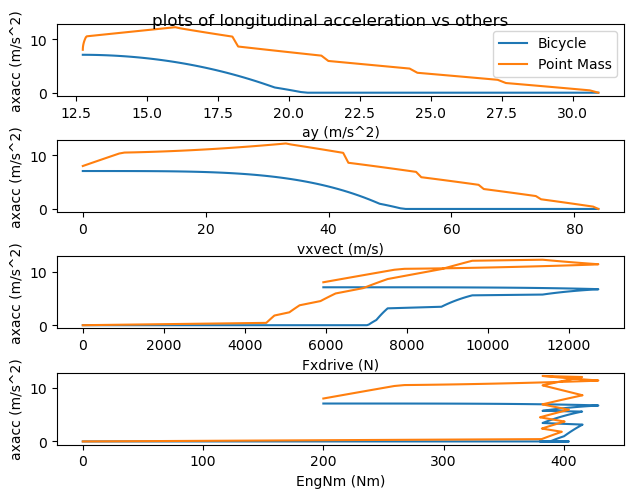

In [ ]:
from casadi import *
import matplotlib.pyplot as plt
from AccEnvCalc import AccEnvCalc
from SetupFileLoader import SetupFileLoader

setupFilesPath = "setupFiles/"
setupFileName = "SetupFile.json"

# SetupFile obj instantiation
s = SetupFileLoader(setupFilesPath + setupFileName)
s.loadJSON()

# Run Acceleration Envelope
aE = AccEnvCalc(s.setupDict)
aE.Run()

# x = SX.sym('x'); y = SX.sym('y'); z = SX.sym('z')

# nlp = {'x':vertcat(x,y,z), 'f':x**2+100*z**2, 'g':z+(1-x)**2-y}
# S = nlpsol('S', 'ipopt', nlp)
# disp(S)

#Bicycle Model 

axacc = [0]*len(aE.accEnvDict["vxvect"])

for index, v in enumerate(aE.accEnvDict["vxvect"]):

    LOAD_EFF_SCALE = 10000

    # aE.mcar = 740
    cogx = 1.78
    cogz = 0.31
    # aE.g = 9.81
    wheelbase = 3.12
    # aE.gripx = 1.15

    W_R = aE.mcar * aE.g * cogx / wheelbase # long. weight transfer rear 
    W_F = aE.mcar * aE.g - W_R # long. weight transfer front

    # [old] i = 5; Fz_aero[i] = 4108.378429795827; Fxgrip[i] = 11584.638986282649; Fxaero_[i] = 1325.2833644502668; Fxdrive[i] = 7338.889980531738; axacc[i] = 8.126495427137122
    # [old] vxvect[25] = 42.806122453877556; Fz_aero[i] = 3465.0005500432576; Fxgrip[i] = 11008.174362709; Fxaero_[i] = 1117.7421129171798; Fxdrive[i] = 8813.373435419537; axacc[i] = 10.399501787165347
    # [trying now] vxvect[47] = 80.47551020448981; Fz_aero[i] = 12246.697941394536; Fxgrip[i] = 18054.66353677579; Fxaero_[i] = 3950.5477230304955; Fxdrive[i] = 4590.467997206904; axacc[i] = 0.8647571272654173
    # [trying now] vxvect[19] = 32.53265306734695; Fz_aero[i] = 2001.3843180002784; Fxgrip[i] = 9661.314616045227; Fxaero_[i] = 645.6078445162188; Fxdrive[i] = 11425.606197737097; axacc[i] = 12.183387529093254
    C_0 = aE.accEnvDict["Fxdrive"][index] # Fxdrive[i]
    C_1 = aE.accEnvDict["Fzaero"][index] + W_F # Fz_aero[i] + weight transfer front
    C_2 = aE.mcar * cogz / (aE.g * wheelbase)
    C_3 = aE.accEnvDict["Fxaero"][index] # Fxaero[i]
    C_4 = aE.accEnvDict["Fzaero"][index] + W_R # Fz_aero[i] + weight transfer rear


    a = MX.sym('a') # acceleration
    g = MX.sym('g') # grip
    F = MX.sym('F')
    x = MX.sym('x')
    y = MX.sym('y')

    gripLoadEffFunc = Function('gripLoadEffFunc', [g, F],\
                            [F, g - g * F / LOAD_EFF_SCALE], \
                                ['g', 'F'], ['F_in', 'F_loadEff'])

    # gripLoadEffFuncSX = gripLoadEffFunc.expand()

    maxFunc = Function('maxFunc', [x,y],\
                        [y, 0.5*(x + y + sqrt((x-y)**2+0.01))], \
                            ['x', 'y'], ['x_in', 'm'])

    minFunc = Function('minFunc', [x, y], \
                [y, 0.5*(x + y - sqrt((x-y)**2+0.01))], \
                    ['x', 'y'], ['x_in', 'm'])

    # max0Func = Function('max0Func', [x],\
    #             (x, x + sqrt(x**2)) / 2)

    # arg = [gripx, x - y * a]
    # res = gripLoadEffFunc(arg)

    res = gripLoadEffFunc(aE.gripx, x - y * a)
    F_long = ('F_long', [x, y, a], 
                [(x - y * a) * res[1] - C_3])

    resC1_C2 = gripLoadEffFunc(aE.gripx, C_1 - C_2 * a)
    resC2_C4 = gripLoadEffFunc(aE.gripx, C_4 + C_2 * a)

    resMin01 = minFunc(C_0, (C_1 - C_2 * a) * resC1_C2[1] - C_3)
    resMin02 = minFunc(C_0, (C_4 + C_2 * a) * resC2_C4[1] - C_3)

    resMaxFunc01 = maxFunc(0, 0.5*(C_0 + (C_1 - C_2 * a) * resC1_C2[1] - C_3 - sqrt((C_0-(C_1 - C_2 * a)*resC1_C2[1]+C_3)**2)))
    resMaxFunc02 = maxFunc(0, 0.5*(C_0 + (C_4 + C_2 * a) * resC2_C4[1] - C_3 - sqrt((C_0-(C_4 + C_2 * a)*resC2_C4[1]+C_3)**2)))

    # resMaxFunc01 = maxFunc(0, resMin01)
    # resMaxFunc02 = maxFunc(0, resMin02)

    constraint =  a - ((resMaxFunc01[1] + resMaxFunc02[1]) / aE.mcar)
    # print(type(constraint))
        
    nlp = {'x': a, 'f': ((resMaxFunc01[1] + resMaxFunc02[1]) / aE.mcar)
                                    , 'g': constraint}

    solver = nlpsol('S', 'ipopt', nlp)
    # print(S)

    sol = solver(x0=0.1, lbg=0, ubg=0)
    axacc[index] = sol['x'].__float__()
    print(f"Optimal acceleration: {sol['x']}")

print(axacc)

fig, axs = plt.subplots(4)
fig.tight_layout() 
fig.suptitle('plots of longitudinal acceleration vs others')
axs[0].plot(aE.accEnvDict["ay"], axacc, label="Bicycle")
axs[0].plot(aE.accEnvDict["ay"], aE.accEnvDict["axacc"], label="Point Mass" )
axs[0].set_xlabel('ay (m/s^2)')
axs[0].set_ylabel('axacc (m/s^2)')
axs[0].legend()

axs[1].plot(aE.accEnvDict["vxvect"], axacc, label="BM")
axs[1].plot(aE.accEnvDict["vxvect"], aE.accEnvDict["axacc"], label="PM" )
axs[1].set_xlabel('vxvect (m/s)')
axs[1].set_ylabel('axacc (m/s^2)')


axs[2].plot(aE.accEnvDict["Fxdrive"], axacc, label="BM")
axs[2].plot(aE.accEnvDict["Fxdrive"], aE.accEnvDict["axacc"], label="PM" )
axs[2].set_xlabel('Fxdrive (N)')
axs[2].set_ylabel('axacc (m/s^2)')


axs[3].plot(aE.accEnvDict["EngNm"], axacc, label="BM")
axs[3].plot(aE.accEnvDict["EngNm"], aE.accEnvDict["axacc"], label="PM" )
axs[3].set_xlabel('EngNm (Nm)')
axs[3].set_ylabel('axacc (m/s^2)')
